###  Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Datasets.Datasets_Functions import *
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph
from Common_Modules.Visualization import Visualization
from Common_Modules.General_Functions import General_Functions


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\traitlets\config\application.py", line 1075, in launch

### Switches

In [2]:
plot_is_enabled = True
two_rings_is_enabled = False
three_rings_is_enabled = False
one_ring_with_two_gaussians_is_enabled = False
three_rings_paper_is_enabled = False
graph_is_enabled = True
real_dataset_is_enabled = False
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = False
globalKernelKMeansPP_is_enabled = False

### Global Variables

In [3]:
seed = 42
evaluator = Evaluator()
n_candidates = n_init = 100
kernel = 'linear'
gamma = 1.0

### Visualization

In [4]:
visualization = Visualization()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

### Load Dataset

### 2Rings

In [5]:
if(two_rings_is_enabled):
    # centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]
    centers_coordinates = [(-1, 2), (2, 2)]
    rings = Rings(colors=colors)
    
    X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)
    rings.plot(X, y)
    
    K = 2 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### 3Rings

In [6]:
if (three_rings_is_enabled):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    rings = Rings(colors=colors)

    centers_coordinates = [(0, 0)]
    X, y = rings.make_concentric_rings(centers_coordinates=centers_coordinates, n_samples=150, radii=[1, 10, 25], noise=0)
    rings.plot(X, y)
    
    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='sigmoid')

### 1 Ring with 2 Gaussians Inside

In [7]:
if(one_ring_with_two_gaussians_is_enabled):
    colors = ['purple', 'orange', 'blue', 'red', 'green', 'lime']
    
    rings = Rings(colors)
    centers_coordinates = [(5, 5), (-5, 5)]
    X, y = rings.make_multiple_rings_with_gaussians(centers_coordinates, n_samples=100, radius=3, noise=0.0, gaussian_samples=50)
    
    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=0.5)

### 3Rings Paper

In [8]:
if (three_rings_paper_is_enabled):
    rings = Rings(colors=colors)
    K = 3
    X, y, kernel_matrix = rings.global_kernel_k_means_three_rings()
    rings.plot(X,y)

### Graphs

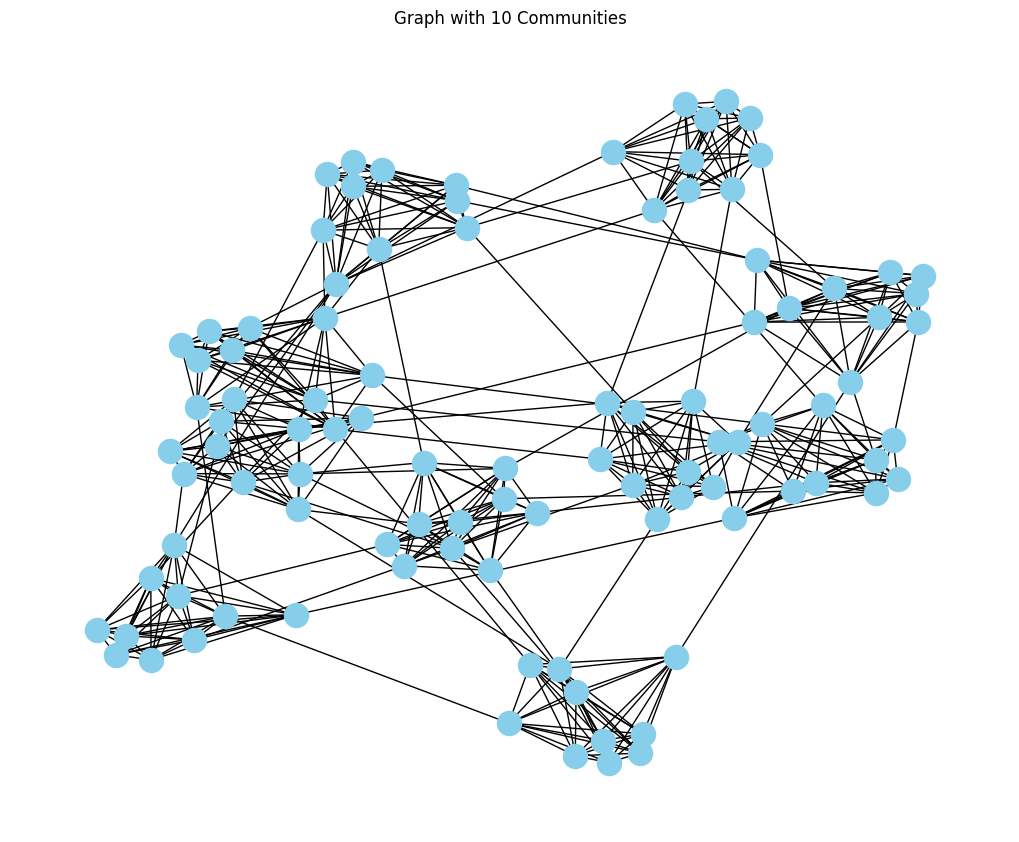

Directory 'Results\Graph_nodes_per_community_10_p_intra_1_p_inter_0.01\linear\100\' created successfully.


In [9]:
if(graph_is_enabled):
    K = 10
    graph = Graph(n_communities=K, n_nodes_per_community=10, p_intra=1, p_inter=0.01, colors=colors)
    dataset_name = f"Graph_nodes_per_community_{graph.n_nodes_per_community}_p_intra_{graph.p_intra}_p_inter_{graph.p_inter}"
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='linear')
    data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
    General_Functions().create_directory(data_dir_path)

### Real Dataset

In [10]:
if (real_dataset_is_enabled):
    dataset_names = ["breast_cancer", "dermatology", "ecoli", "iris", "olivetti_faces", "pendigits", "waveform_v1", "wine"]
    dataset_name = dataset_names[0] 
    module_name = "Datasets.Datasets"
    batch_size = 16
    dataloader, input_dim, X, y = function_get_dataset(dataset_name, module_name, batch_size)
    print('Date Number is:', len(y))
    print('Data_Shape is:', input_dim)
    K = len(np.unique(y))
    kernel_matrix = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
    General_Functions().create_directory(data_dir_path)
    K = 50

### kMeans

In [11]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    if(plot_is_enabled):
        visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans

In [12]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    if(plot_is_enabled):
        visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans++

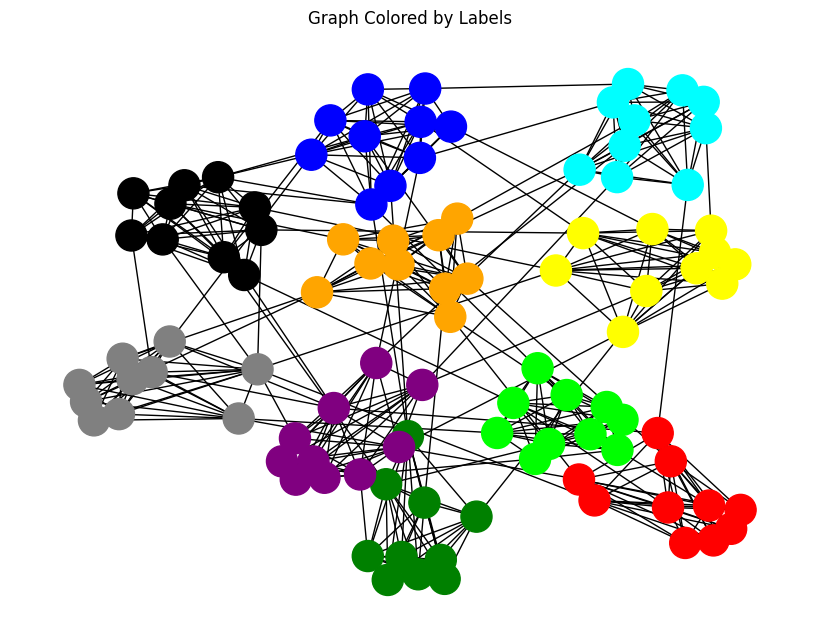

In [17]:
if(kernelKMeansPP_is_enabled):
    initialization_methods = ["forgy", "random", "k-means++"]
    n_iters_ = {}
    execution_times_ = {}
    inertias_ = {}
    init = initialization_methods[2]
    prev_K = K
    K = K
    while (K != prev_K + 1):
        kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=n_init, init=init, verbose=0)
        kernelKMeans.fit()
        
        if(plot_is_enabled):
            if graph_is_enabled:
                graph.plot_clusters(kernelKMeans.labels_)
            else:
                visualization.plot_tsne(X, y, data_dir_path=data_dir_path + "KernelKMeans_" + init)                
        
        n_iters_[K] = sum(kernelKMeans.n_iters_.values())
        execution_times_[K] = sum(kernelKMeans.execution_times_.values())
        inertias_[K] = kernelKMeans.inertia_
        new_row = { "K": K, "MSE": inertias_[K], "ITERATIONS": n_iters_[K], "EXECUTION TIME": execution_times_[K]}
        General_Functions.append_to_csv(f"{data_dir_path}KernelKMeans_Dataset_{dataset_name}_Init_{init}_Kernel_{kernel}_K_{prev_K}_Inits_{n_init}_Results.csv", new_row)
        K += 1
    K = prev_K   

### Global Kernel kMeans

In [14]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeans.fit()
    
    if(plot_is_enabled):
        if graph_is_enabled:
            graph.plot_clusters(globalKernelKMeans.labels_[K])
        else:
            visualization.plot_tsne(X, y, data_dir_path=f"{data_dir_path}GlobalKernelKMeans")

### Global Kernel kMeans++

In [15]:
if(globalKernelKMeansPP_is_enabled):
    sampling_methods = ["sequential", "batch"]
    sampling = sampling_methods[0] 
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=n_candidates, sampling=sampling, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Sampling_{sampling}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeansPP.fit()
    
    acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
    if(plot_is_enabled):
        if graph_is_enabled:
            graph.plot_clusters(globalKernelKMeansPP.labels_[K])
        else:
            visualization.plot_tsne(X, y, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_{sampling}_")